# Time Series Forecasting with Linear Regression

# SageMaker

## Introduction

Adapted from the SageMaker tutorial [Time Series Forecasting with Linear Learner](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/linear_time_series_forecast/linear_time_series_forecast.ipynb)

‘Time’ is the most important factor which ensures success in a business. It’s difficult to keep up with the pace of time.  But, technology has developed some powerful methods using which we can ‘see things’ ahead of time (without building a time machine).

In this notebook, we will introduce the methods of prediction & forecasting. One such method, which deals with time based data is Time Series Modeling. As the name suggests, it involves working on time (years, days, hours, minutes) based data, to derive hidden insights to make informed decision making.

Time series models are very useful models when you have serially correlated data. Many businesses will use time series data to predict sales number for the next year, website traffic, competition position and more.

Let's begin by importing some libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'

We can download the data file (.csv) directly from the web. More information about this dataset can be found [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html).  

Note: To run a terminal command within jupyter, simply add `!` before the command.

In [0]:
!wget https://robjhyndman.com/data/gasoline.csv

--2018-03-05 13:44:54--  https://robjhyndman.com/data/gasoline.csv
Resolving robjhyndman.com (robjhyndman.com)... 77.104.152.218
Connecting to robjhyndman.com (robjhyndman.com)|77.104.152.218|:443... connected.
...���������� ���������� ���������� ,���������� HTTP ���������� 200 OK
Length: 4530 (4.4K) [text/csv]
Saving to: ���gasoline.csv.6���

gasoline.csv.6      100%[===================>]   4.42K  --.-KB/s    in 0s      

2018-03-05 13:44:54 (103 MB/s) - ���gasoline.csv.6��� saved [4530/4530]



Now that we have the datafile downloaded, we can import it to a Pandas DataFrame and start examining the data 

In [0]:
gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
gas.head()

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


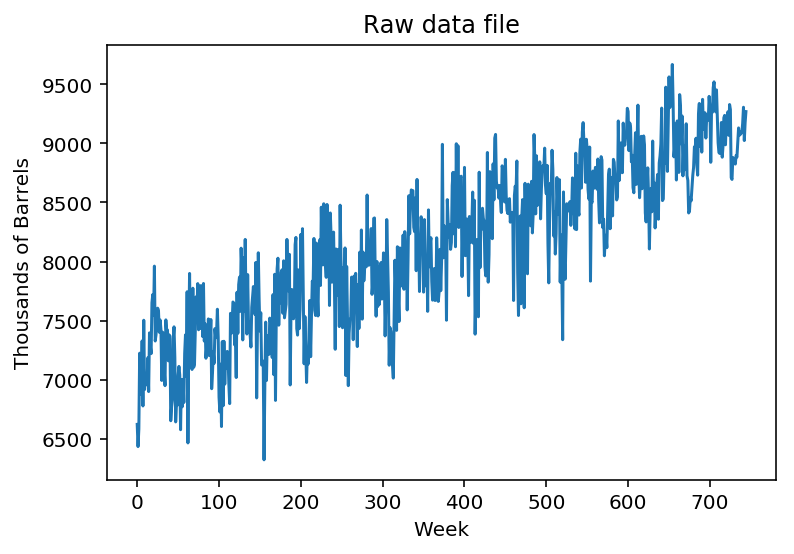

In [0]:
plt.plot(gas)
plt.title('Raw data file')
plt.xlabel('Week')
plt.ylabel('Thousands of Barrels')
plt.show()

As we can see, there's a definitive upward trend, some yearly seasonality, but sufficient volatility to make the problem non-trivial. There are several unexpected dips and years with more or less pronounced seasonality. These same characteristics are common in many topline time-series.


## Pre-processing

In [0]:
gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
gas['trend'] = np.arange(len(gas))
gas['log_trend'] = np.log1p(np.arange(len(gas)))
gas['sq_trend'] = np.arange(len(gas)) ** 2
weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
gas = pd.concat([gas, weeks], axis=1)
gas.head()

,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,NaN,NaN,NaN,NaN,0,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6433.0,6621.0,NaN,NaN,NaN,1,0.693147,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6582.0,6433.0,6621.0,NaN,NaN,2,1.098612,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7224.0,6582.0,6433.0,6621.0,NaN,3,1.386294,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0


We see that the data contains many missing datapoints. We can use `bfill` which uses NEXT valid observation to fill gap.

In [0]:
gas = gas.fillna(method='bfill')
gas.head()

,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
0,6621.0,6621.0,6621.0,6621.0,6621.0,0,0.000000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,6433.0,6621.0,6621.0,6621.0,6621.0,1,0.693147,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6582.0,6433.0,6621.0,6621.0,6621.0,2,1.098612,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7224.0,6582.0,6433.0,6621.0,6621.0,3,1.386294,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
gas = gas.iloc[4:, ]
split_train = int(len(gas) * 0.8)
split_test = int(len(gas) * 0.8)

train_y = gas['thousands_barrels'][:split_train]
train_X = gas.drop('thousands_barrels', axis=1).iloc[:split_train, ].as_matrix()
test_y = gas['thousands_barrels'][split_train:]
test_X = gas.drop('thousands_barrels', axis=1).iloc[split_train:, ].as_matrix()

## Modeling

In [0]:
lr = LinearRegression()
lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [0]:
y_pred = lr.predict(test_X)

In [0]:
gas['thousands_barrels_lag52'] = gas['thousands_barrels'].shift(52)
gas['thousands_barrels_lag104'] = gas['thousands_barrels'].shift(104)
gas['thousands_barrels_naive_forecast'] = gas['thousands_barrels_lag52'] ** 2 / gas['thousands_barrels_lag104']
naive = gas[split_test:]['thousands_barrels_naive_forecast'].as_matrix()

## Prediction and Evaluation

There are many metrics to measure forecast error. Common examples include include:
* Root Mean Square Error (RMSE)
* Mean Absolute Percent Error (MAPE)
* Geometric Mean of the Relative Absolute Error (GMRAE)
* Quantile forecast errors
* Errors that account for asymmetric loss in over or under-prediction


For our example we'll keep things simple and use Root Mean Square Error (RMSE), but we'll also compare it to a naive benchmark forecast (that week last year's demand * that week last year / that week two year's ago).

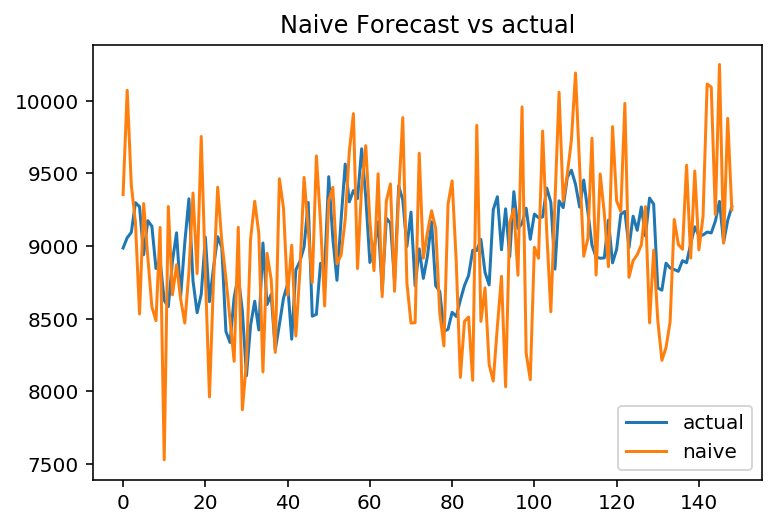


Naive Root Mean Squared Error (RMSE)= 515


In [0]:
# print('Naive MdAPE =', np.median(np.abs(test_y - naive) / test_y))

plt.plot(np.array(test_y), label='actual')
plt.plot(naive, label='naive')
plt.title('Naive Forecast vs actual')
plt.legend()
plt.show()

print('')
print('Naive Root Mean Square Error (RMSE)=', round(sqrt(mean_squared_error(test_y, naive))))

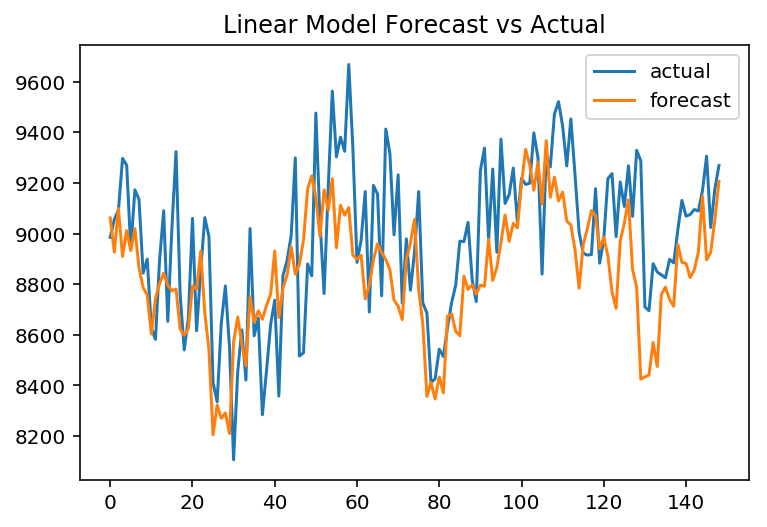


Predicted Root Mean Squared Error (RMSE)= 70951.0


In [0]:
# print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - y_pred) / test_y))

plt.plot(np.array(test_y), label='actual')
plt.plot(y_pred, label='forecast')
plt.title('Linear Model Forecast vs Actual')
plt.legend()
plt.show()

print('')
print('Predicted Root Mean Square Error (RMSE)=', round(mean_squared_error(test_y, y_pred)))

## Conclusions

Our linear model does a good job of predicting gasoline demand, but of course, improvements could be made. The fact that statistical forecast actually underrepresents some of the volatility in the data could suggest that we have actually over-regularized the data. Or, perhaps our choice of absolute loss was incorrect. Rerunning the model with further tweaks to these hyperparameters may provide more accurate out of sample forecasts. 

We also did not do a large amount of feature engineering. Occasionally, the lagging time-periods have complex interrelationships with one another that should be explored. Finally, alternative forecasting algorithms could be explored. Less interpretable methods like ARIMA, and black-box methods like LSTM Recurrent Neural Networks have been shown to predict time-series very well. 

Balancing the simplicity of a linear model with predictive accuracy is an important subjective question where the right answer depends on the problem being solved, and its implications to the business.


# AnalyticsVidhya

In [48]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

vodafone = pd.read_csv('pageviews.csv', 
                       encoding='utf-8', 
                       index_col='Date',
                       parse_dates=['Date'],
                       date_parser=dateparse
                      )
print(vodafone.shape)
vodafone.head()

(916, 1)


,Vodafone
Date,
2015-07-01,2098
2015-07-02,2008
2015-07-03,1699
2015-07-04,1323
2015-07-05,1472


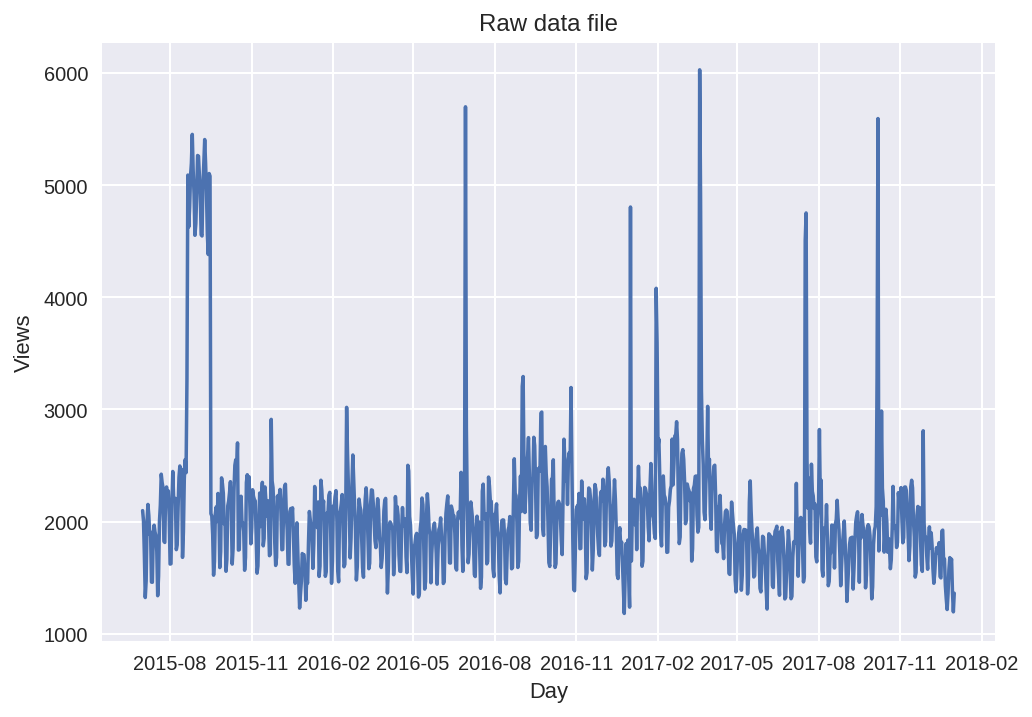

In [49]:
plt.plot(vodafone)
plt.title('Raw data file')
plt.xlabel('Day')
plt.ylabel('Views')
plt.show()

In [50]:
vodafone.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
               '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30',
               '2017-12-31', '2018-01-01'],
              dtype='datetime64[ns]', name='Date', length=916, freq=None)

In [51]:
data = vodafone['Vodafone']
data.head(10)

Date
2015-07-01    2098
2015-07-02    2008
2015-07-03    1699
2015-07-04    1323
2015-07-05    1472
2015-07-06    2002
2015-07-07    2153
2015-07-08    2055
2015-07-09    1886
2015-07-10    1906
Name: Vodafone, dtype: int64

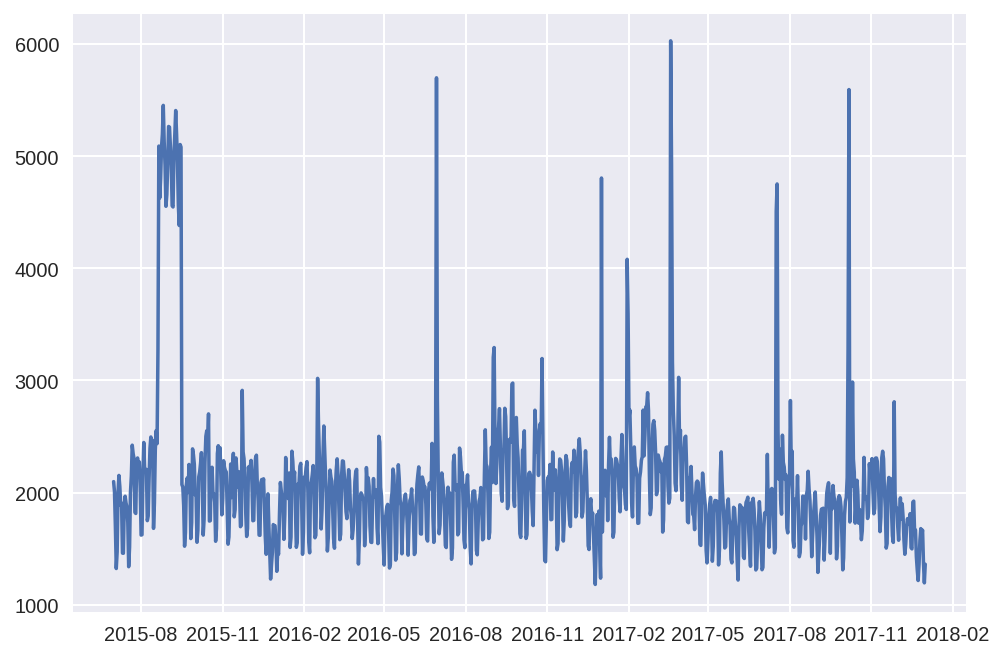

In [52]:
plt.plot(data)

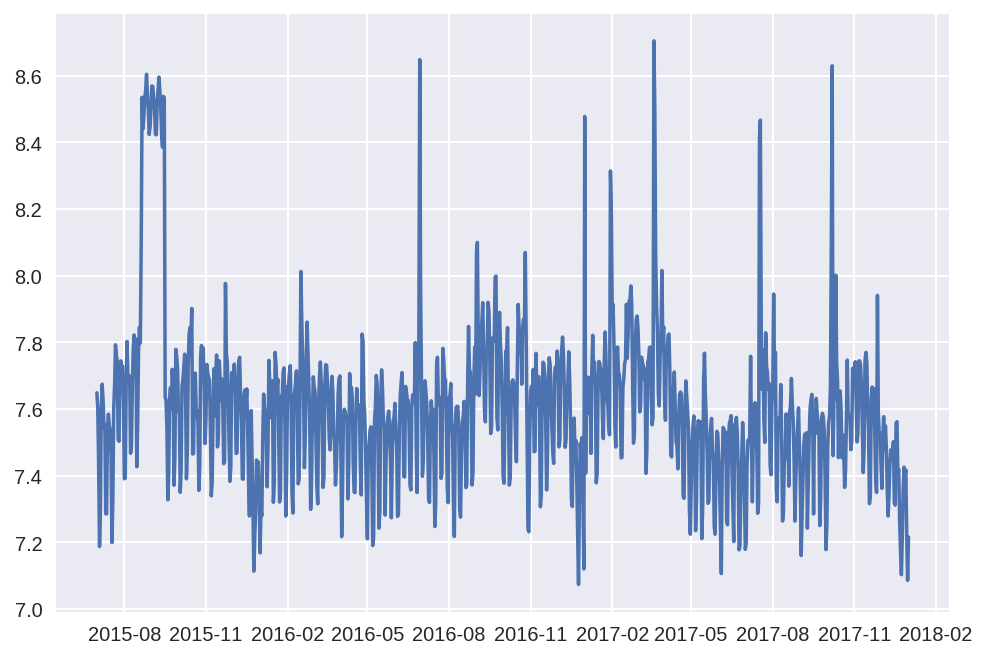

In [53]:
ts_log = np.log(data)
plt.plot(ts_log)

In [66]:
ts_log.head()

Date
2015-07-01    7.648740
2015-07-02    7.604894
2015-07-03    7.437795
2015-07-04    7.187657
2015-07-05    7.294377
Name: Vodafone, dtype: float64

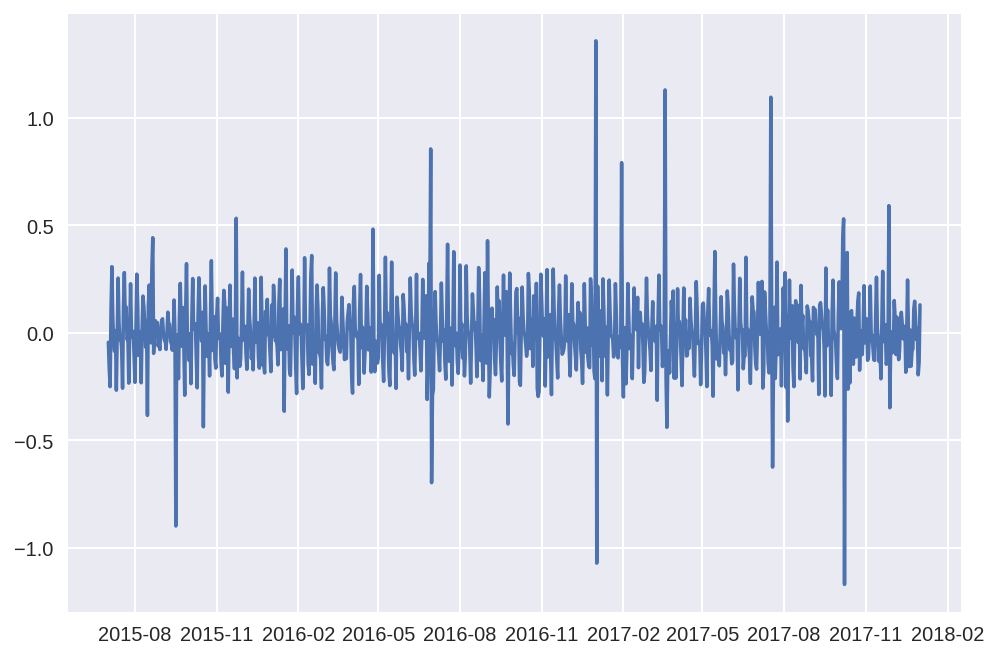

In [54]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [0]:
ts_log_diff.dropna(inplace=True)

In [1]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 2))
results = model.fit(disp=0)

plt.plot(ts_log_diff)
plt.plot(results.fittedvalues, color='r')
plt.title('RSS: %.4f' % sum((results.fittedvalues - ts_log_diff)**2))

C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


NameError: name 'ts_log' is not defined

In [225]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2015-07-02   -0.000210
2015-07-03   -0.000654
2015-07-04    0.008696
2015-07-05    0.071061
2015-07-06    0.128317
dtype: float64

In [226]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2015-07-02   -0.000210
2015-07-03   -0.000864
2015-07-04    0.007832
2015-07-05    0.078892
2015-07-06    0.207209
dtype: float64

In [227]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2015-07-01    7.648740
2015-07-02    7.648529
2015-07-03    7.647876
2015-07-04    7.656571
2015-07-05    7.727632
dtype: float64

In [228]:
all = pd.DataFrame()
all['original'] = ts_log
all['predictions'] = predictions_ARIMA_log
all.head(20)

,original,predictions
Date,,
2015-07-01,7.648740,7.648740
2015-07-02,7.604894,7.648529
2015-07-03,7.437795,7.647876
2015-07-04,7.187657,7.656571
2015-07-05,7.294377,7.727632
2015-07-06,7.601902,7.855948
2015-07-07,7.674617,7.907395
2015-07-08,7.628031,7.840379
2015-07-09,7.542213,7.718736


Text(0.5,1,'RMSE: 937.9400')

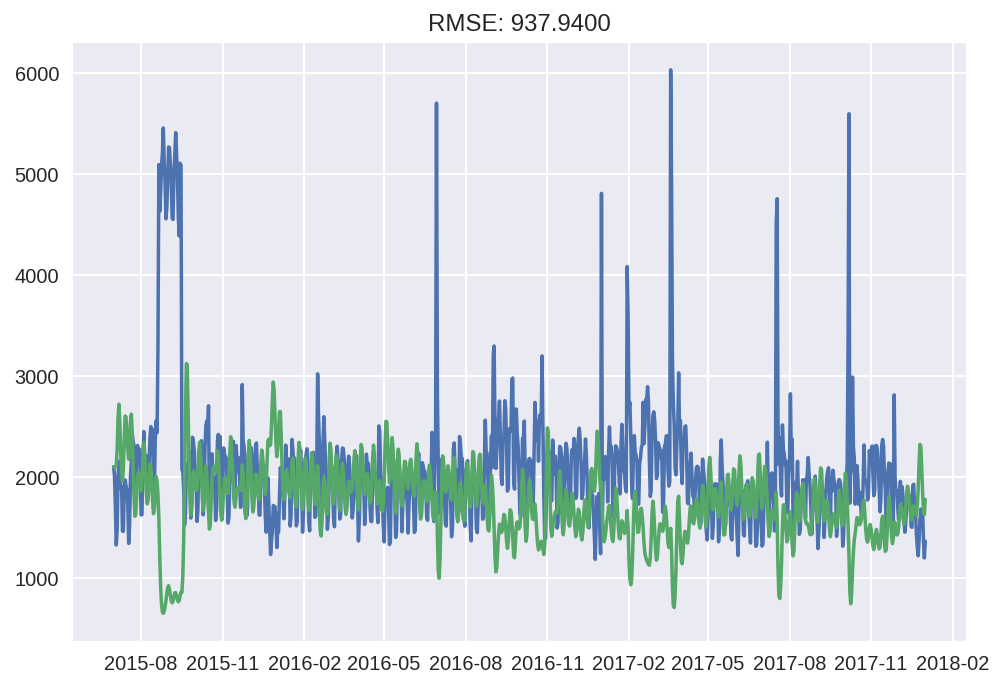

In [229]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

# MLM - ARMIA

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


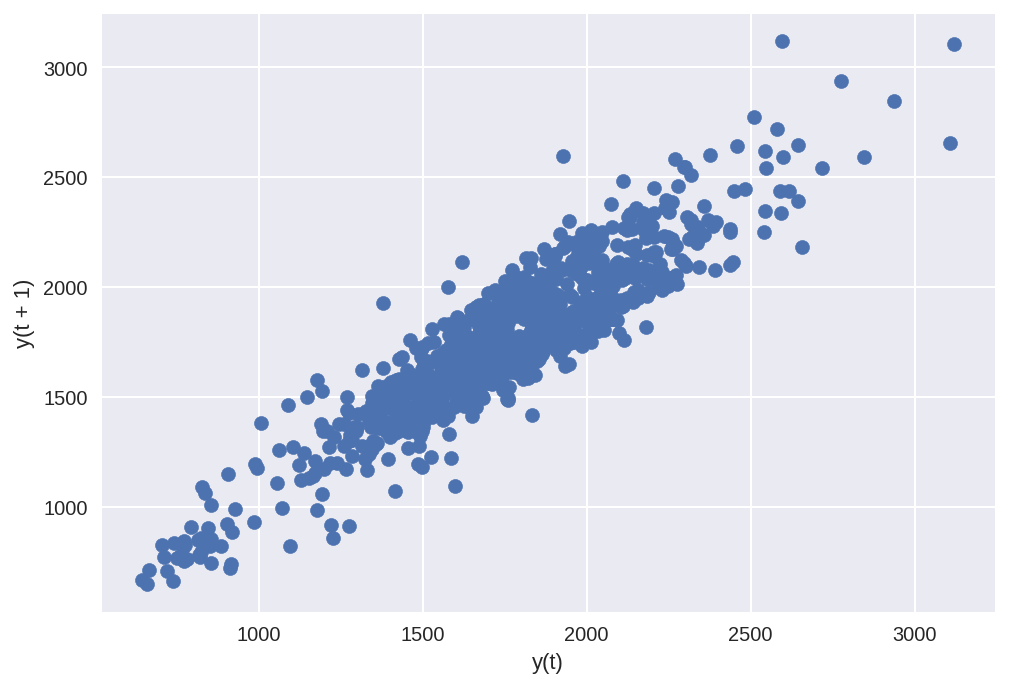

In [73]:
# Quick check using a lag plot to show correlation
from pandas.tools.plotting import lag_plot, autocorrelation_plot
   
ts_lag = lag_plot(predictions_ARIMA)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


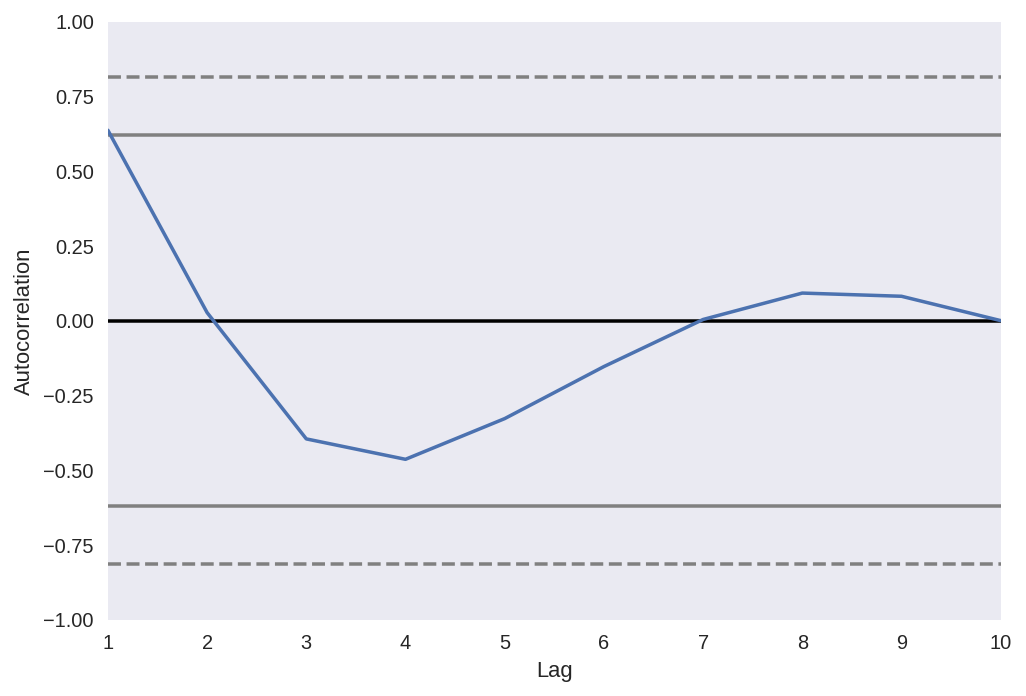

In [161]:
autocorrelation_plot(predictions_ARIMA[:10])
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:             D.Vodafone   No. Observations:                  915
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6899.305
Method:                       css-mle   S.D. of innovations            455.446
Date:                Tue, 20 Mar 2018   AIC                          13804.610
Time:                        20:05:47   BIC                          13819.066
Sample:                    07-02-2015   HQIC                         13810.128
                         - 01-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8055     13.503     -0.060      0.952     -27.271      25.660
ar.L1.D.Vodafone    -0.1152      0.033     -3.508      0.000      -0.179      -0.051
                            

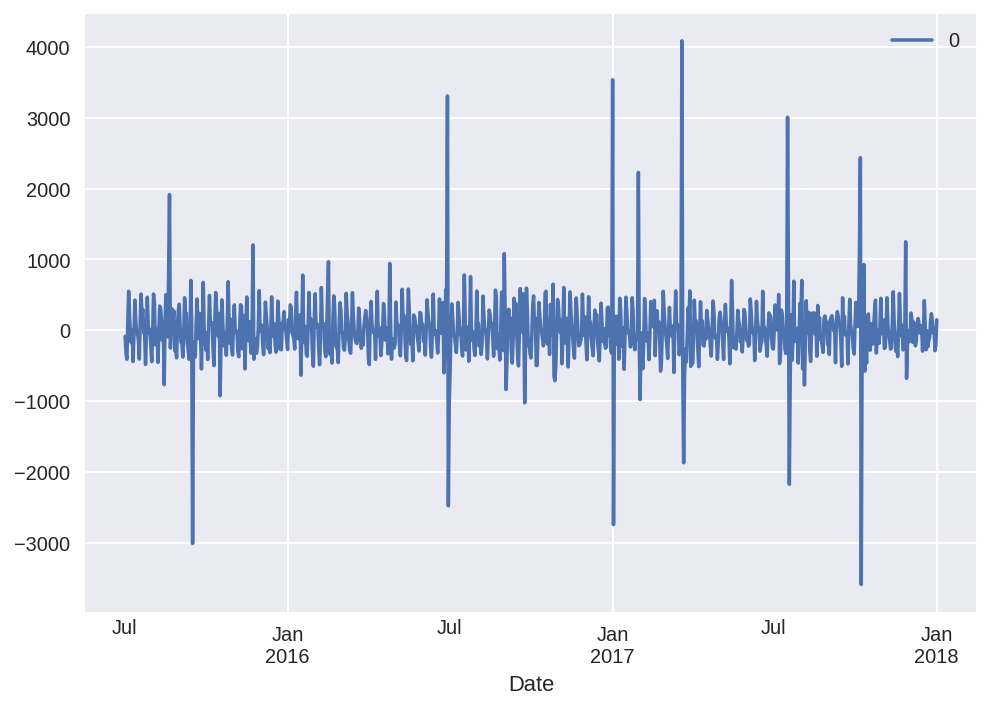

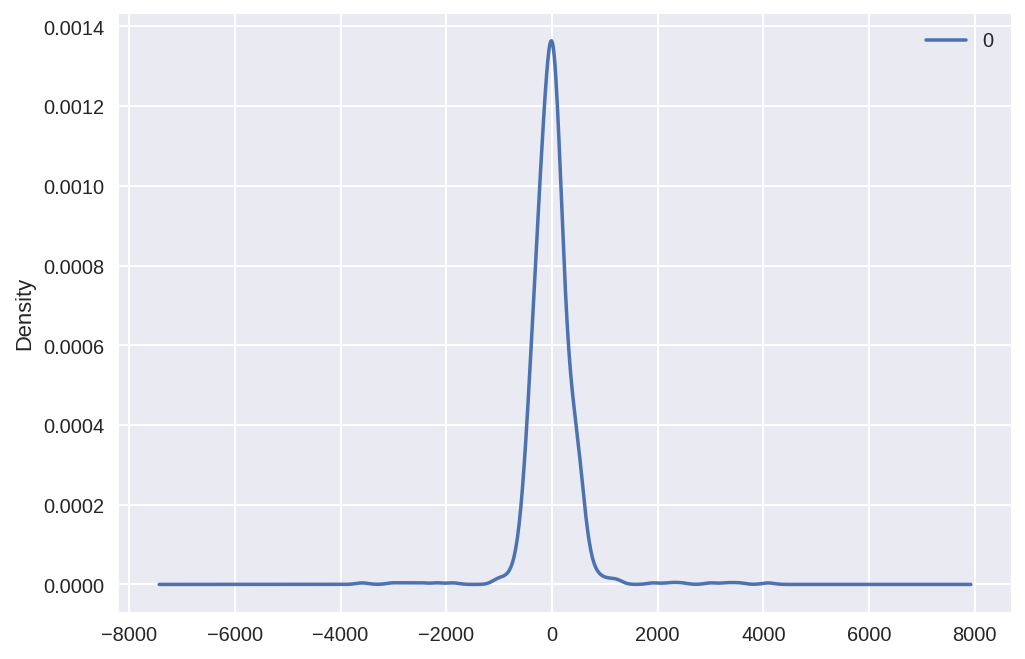

                 0
count   915.000000
mean     -0.020999
std     455.695612
min   -3591.120167
25%    -204.890327
50%     -10.768021
75%     156.452867
max    4085.965226


In [182]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
series = read_csv('pageviews.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = series.astype('float64')
# fit model
model = ARIMA(series, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# # plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [0]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()

In [189]:
len(test)

312

In [190]:
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [191]:
len(predictions), len(test)

(312, 312)

In [192]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 252601.405


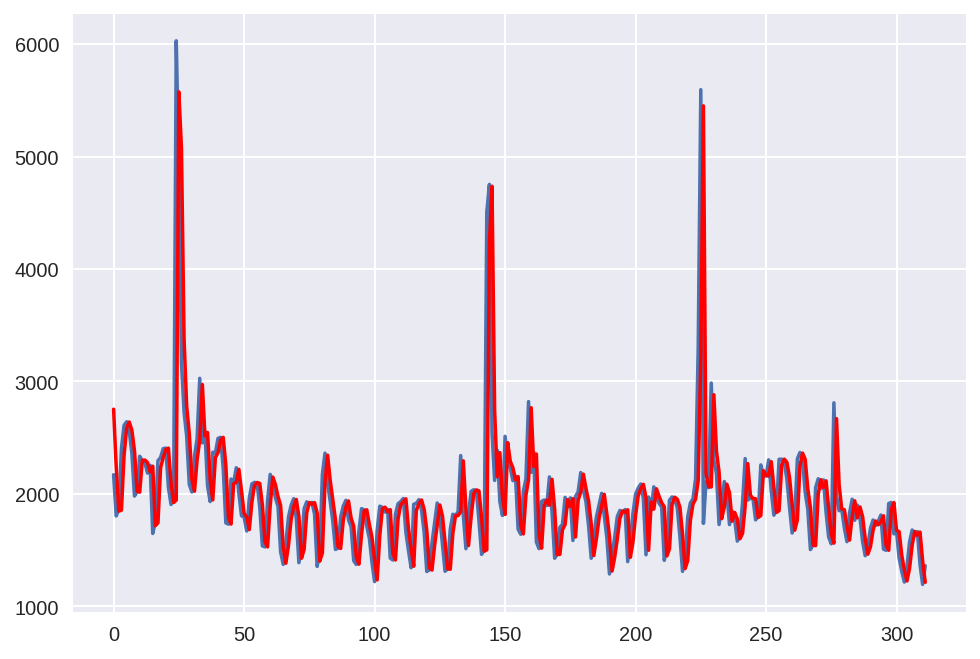

In [193]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# MLM - AR

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [0]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [156]:
series = Series.from_csv('pageviews.csv', header=0)
split = int(len(X)*0.66)
# split dataset
X = series.values
train, test = X[1:split], X[split:]

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


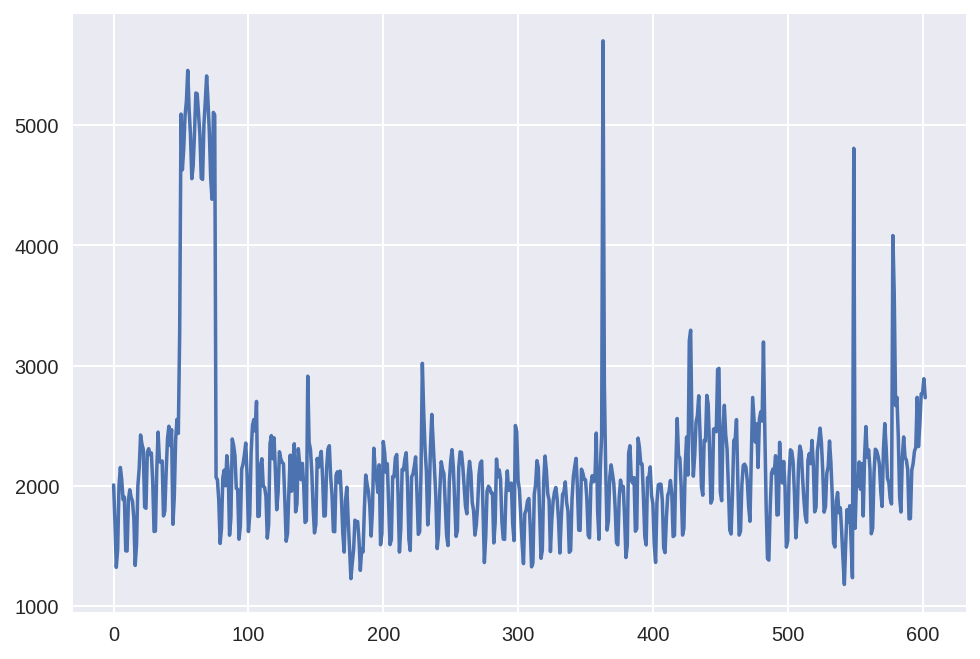

In [157]:
plt.plot(train)

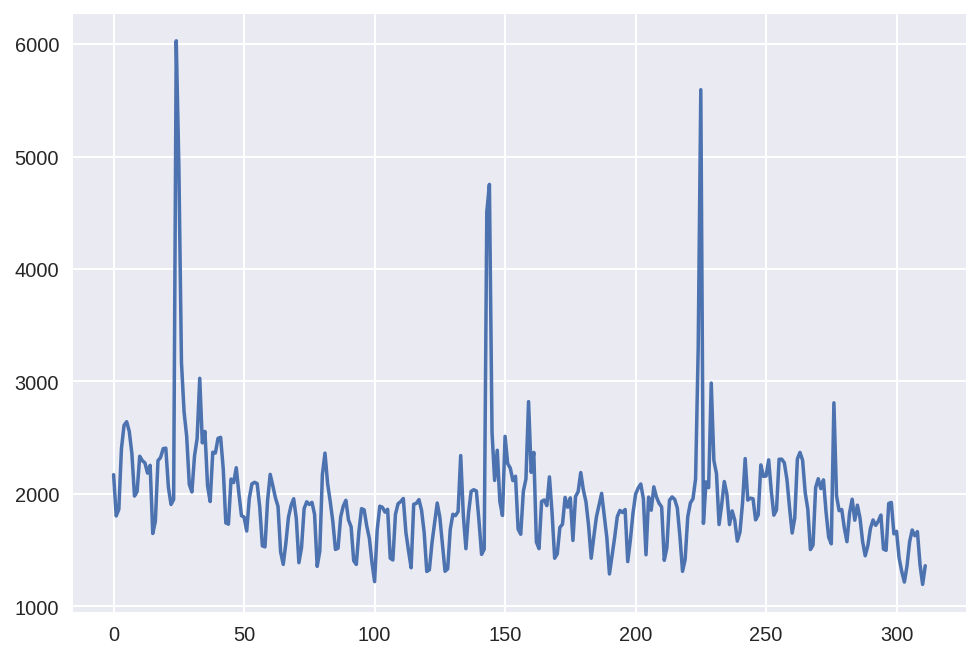

In [123]:
plt.plot(test)

In [115]:
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 19
Coefficients: [ 2.54661688e+02  6.43991090e-01  3.77058613e-02  9.90857140e-02
  1.61711392e-02  7.09676089e-03  1.11607172e-01  1.43442455e-01
 -5.71920665e-02 -9.44147184e-02 -2.86945359e-02 -3.25543528e-02
 -3.56288024e-02  1.09123517e-01  1.54897537e-01 -4.92480764e-02
 -1.14575029e-01 -2.15298090e-02  4.98333633e-04 -6.38786721e-03]


In [116]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=2662.326875, expected=2171.000000
predicted=2485.150001, expected=1804.000000
predicted=2460.016778, expected=1863.000000
predicted=2594.153294, expected=2403.000000
predicted=2647.914183, expected=2610.000000
predicted=2621.403272, expected=2642.000000
predicted=2614.129427, expected=2556.000000
predicted=2573.962256, expected=2360.000000
predicted=2453.321587, expected=1981.000000
predicted=2429.771925, expected=2020.000000
predicted=2519.661508, expected=2335.000000
predicted=2565.520962, expected=2296.000000
predicted=2547.932442, expected=2276.000000
predicted=2498.719150, expected=2185.000000
predicted=2413.424933, expected=2254.000000
predicted=2320.772023, expected=1648.000000
predicted=2300.546219, expected=1756.000000
predicted=2356.596690, expected=2296.000000
predicted=2394.243865, expected=2324.000000
predicted=2381.390810, expected=2403.000000
predicted=2349.552646, expected=2407.000000
predicted=2294.633305, expected=2058.000000
predicted=2228.879803, expected=

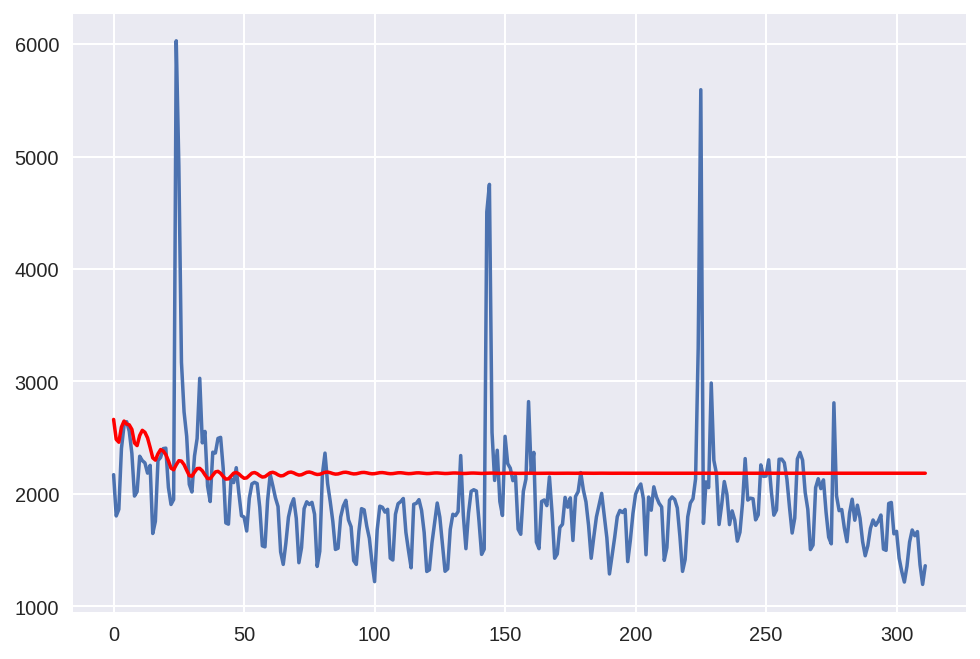

In [117]:
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [0]:
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [119]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=2662.326875, expected=2171.000000
predicted=2168.739871, expected=1804.000000
predicted=2002.836344, expected=1863.000000
predicted=2135.312987, expected=2403.000000
predicted=2426.864583, expected=2610.000000
predicted=2516.121641, expected=2642.000000
predicted=2537.699386, expected=2556.000000
predicted=2379.720877, expected=2360.000000
predicted=2177.173954, expected=1981.000000
predicted=2090.210843, expected=2020.000000
predicted=2296.870908, expected=2335.000000
predicted=2480.176901, expected=2296.000000
predicted=2391.135326, expected=2276.000000
predicted=2250.916340, expected=2185.000000
predicted=1964.660380, expected=2254.000000
predicted=1938.895617, expected=1648.000000
predicted=1770.558193, expected=1756.000000
predicted=2060.782056, expected=2296.000000
predicted=2354.661937, expected=2324.000000
predicted=2297.757152, expected=2403.000000
predicted=2334.054193, expected=2407.000000
predicted=2215.000233, expected=2058.000000
predicted=1883.924831, expected=

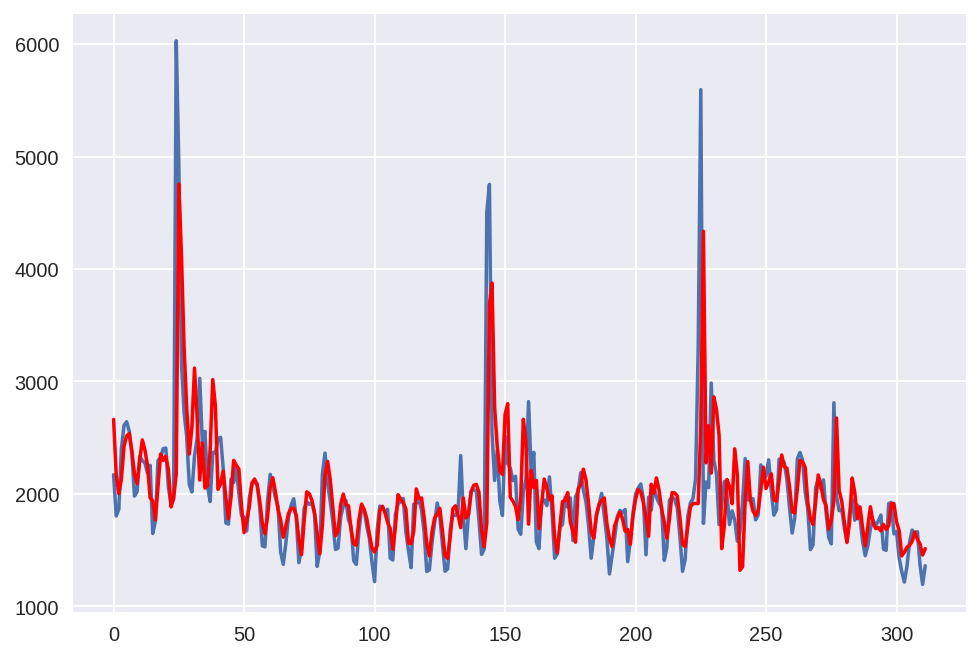

In [120]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()